# ***Downloading Data***

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d c7934597/resized-2015-2019-diabetic-retinopathy-detection

100% 17.3G/17.3G [01:59<00:00, 79.3MB/s]
100% 17.3G/17.3G [02:00<00:00, 155MB/s] 


In [5]:
!unzip /content/resized-2015-2019-diabetic-retinopathy-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: resized_traintest15_train19/8549_left.jpg  
  inflating: resized_traintest15_train19/8549_right.jpg  
  inflating: resized_traintest15_train19/854_left.jpg  
  inflating: resized_traintest15_train19/854_right.jpg  
  inflating: resized_traintest15_train19/8550_left.jpg  
  inflating: resized_traintest15_train19/8550_right.jpg  
  inflating: resized_traintest15_train19/8551_left.jpg  
  inflating: resized_traintest15_train19/8551_right.jpg  
  inflating: resized_traintest15_train19/8552_left.jpg  
  inflating: resized_traintest15_train19/8552_right.jpg  
  inflating: resized_traintest15_train19/8553_left.jpg  
  inflating: resized_traintest15_train19/8553_right.jpg  
  inflating: resized_traintest15_train19/8554_left.jpg  
  inflating: resized_traintest15_train19/8554_right.jpg  
  inflating: resized_traintest15_train19/8555_left.jpg  
  inflating: resized_traintest15_train19/8555_right.jpg  
  inflating: resized_traintest1

# ***Imports***

In [6]:
!pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.0 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from efficientnet.tfkeras import EfficientNetB0
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import shutil

ModuleNotFoundError: No module named 'pandas'

In [1]:
!pip install pandas

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/2d/5e/9213ea10ac473e2437dc2cb17323ddc0999997e2713d6a0b683b10773994/pandas-2.1.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for numpy>=1.23.2 from https://files.pythonhosted.org/packages/93/fd/3f826c6d15d3bdcf65b8031e4835c52b7d9c45add25efa2314b53850e1a2/numpy-1.26.0-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/61.1 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.1 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.1 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.1 kB ? eta -:--:--
     -------------------------------------- 61.1/61.1 kB 406.7 kB/s eta 0:00:00
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/32/4d/aaf7eff5deb402fd9a24a1449a8119f00d74ae9c

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python311\\Scripts\\f2py.exe' -> 'C:\\Python311\\Scripts\\f2py.exe.deleteme'



# ***Loadind Data***

In [2]:
data = pd.read_csv('/content/labels/traintestLabels15_trainLabels19.csv')

NameError: name 'pd' is not defined

# ***Splitting***

In [9]:
def split_data(data_path, c):
    if not os.path.exists('/content/train_directory'):
        os.makedirs('/content/train_directory')
    if not os.path.exists('/content/test_directory'):
        os.makedirs('/content/test_directory')

    i = 0
    for _, row in c.iterrows():
        filename = row['image']
        label = row['level']
        if os.path.exists(os.path.join(data_path,filename+'.jpg')):
            if not os.path.exists(os.path.join('/content/train_directory', str(label))):
                os.makedirs(os.path.join('/content/train_directory', str(label)))
            if not os.path.exists(os.path.join('/content/test_directory', str(label))):
                os.makedirs(os.path.join('/content/test_directory', str(label)))

            target_directory = os.path.join('/content/train_directory', str(label)) if i < 70000 else os.path.join('/content/test_directory', str(label))
            shutil.move(os.path.join(data_path, filename+'.jpg'), target_directory)
            i += 1

In [10]:
split_data('/content/resized_traintest15_train19', data)

In [11]:
def plot_hist(data_path, title):
    subfolders = [f.path for f in os.scandir(data_path) if f.is_dir()]
    subfolder_names = []
    file_counts = []
    for subfolder in subfolders:
        subfolder_name = os.path.basename(subfolder)
        subfolder_names.append(subfolder_name)
        file_count = len(os.listdir(subfolder))
        file_counts.append(file_count)

    plt.bar(subfolder_names, file_counts)
    plt.xlabel('classes')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.xticks()
    plt.show()

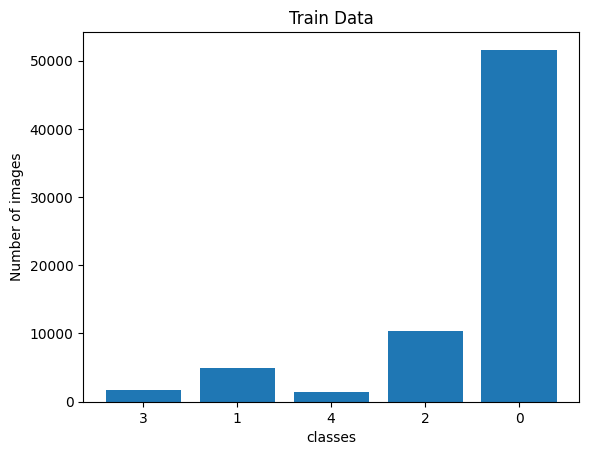

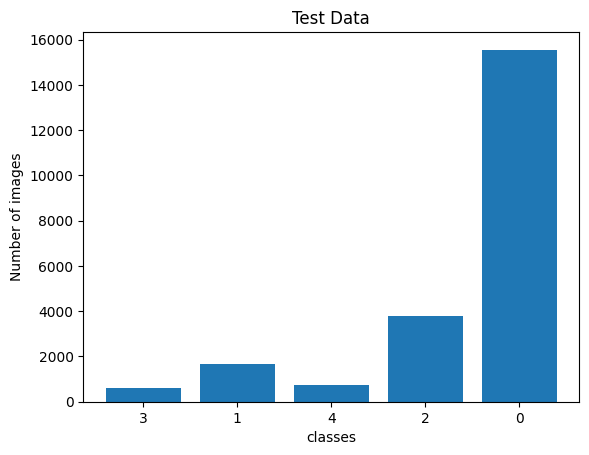

In [12]:
plot_hist('/content/train_directory', 'Train Data')
plot_hist('/content/test_directory', 'Test Data')

# ***Preprocessing and Normalization***

In [2]:
datagen = ImageDataGenerator(
            rescale=1.0/255.0,
            zoom_range=0.15,
            fill_mode='constant',
            cval=0.,
            horizontal_flip=True,
            vertical_flip=True,
            )

img_size = 256
batch_size = 32

train_generator = datagen.flow_from_directory(
    '/content/train_directory',
    target_size=(img_size, img_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
    )

test_generator = datagen.flow_from_directory(
    '/content/test_directory',
    target_size=(img_size, img_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
    )

Found 70000 images belonging to 5 classes.
Found 22364 images belonging to 5 classes.


In [3]:
x,y = next(train_generator)
x.shape

(32, 256, 256, 3)

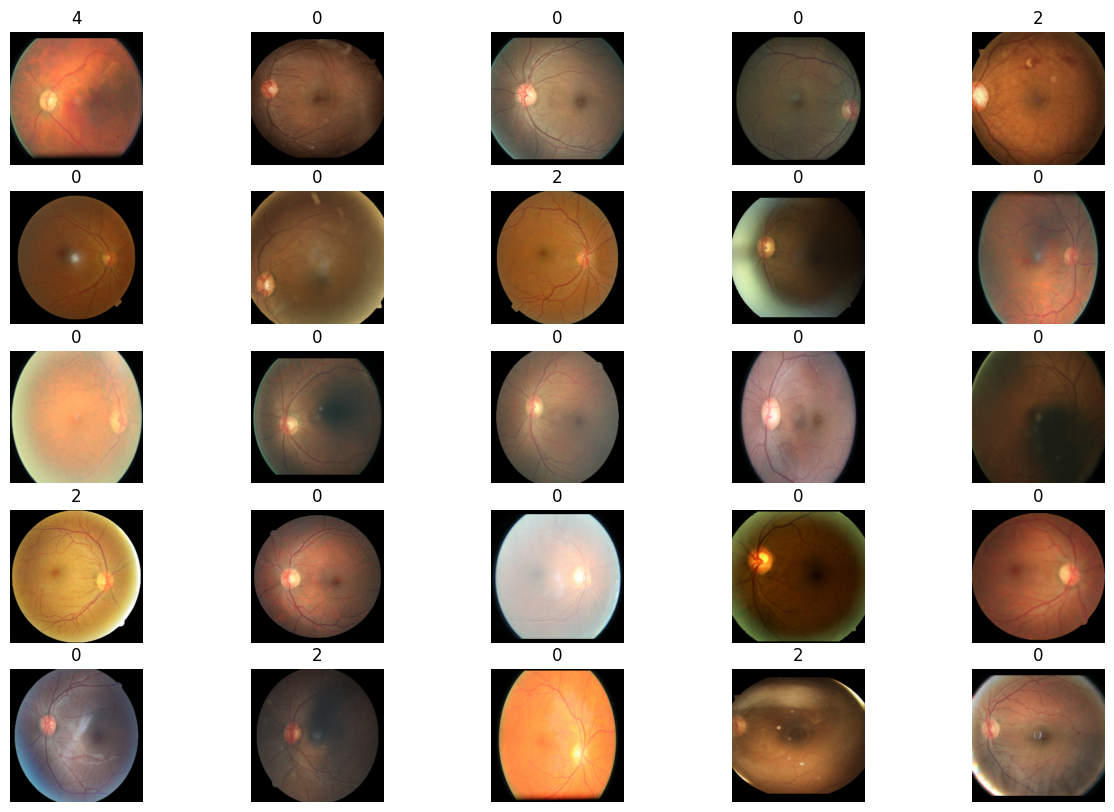

In [4]:
a = train_generator.class_indices
class_names = list(a.keys())
 
def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

# ***Building Model***

In [5]:
def build_Model() -> Sequential:
    model = Sequential()
    model.add(Input(shape=(img_size, img_size, 3)))

    base = EfficientNetB0(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)

    model.add(base)

    model.add(GlobalAveragePooling2D())
    model.add(Dense(len(class_names), activation='softmax'))
    
    return model

In [6]:
model = build_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 8, 8, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 4,055,969
Trainable params: 4,013,953
Non-trainable params: 42,016
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

checkpoint = ModelCheckpoint("diabetic_eye_weights.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=5)

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True)

# ***Training***

In [8]:
history = model.fit(
            train_generator,
            steps_per_epoch=200,
            epochs=1000,
            validation_data=test_generator,
            validation_steps=60,
            callbacks=[checkpoint, early_stop, reduceLROnPlat]
          )

Epoch 1/1000
200/200 [==============================] - ETA: 0s - loss: 0.8303 - accuracy: 0.7308 - auc: 0.9092
Epoch 1: val_loss improved from inf to 1.27164, saving model to diabetic_eye_weights.h5
200/200 [==============================] - 365s 2s/step - loss: 0.8303 - accuracy: 0.7308 - auc: 0.9092 - val_loss: 1.2716 - val_accuracy: 0.6974 - val_auc: 0.8749 - lr: 0.0010
Epoch 2/1000
200/200 [==============================] - ETA: 0s - loss: 0.7301 - accuracy: 0.7553 - auc: 0.9284
Epoch 2: val_loss improved from 1.27164 to 0.99718, saving model to diabetic_eye_weights.h5
200/200 [==============================] - 280s 1s/step - loss: 0.7301 - accuracy: 0.7553 - auc: 0.9284 - val_loss: 0.9972 - val_accuracy: 0.7344 - val_auc: 0.9092 - lr: 0.0010
Epoch 3/1000
200/200 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.7663 - auc: 0.9325
Epoch 3: val_loss improved from 0.99718 to 0.74124, saving model to diabetic_eye_weights.h5
200/200 [=============================

# ***Evaluation***

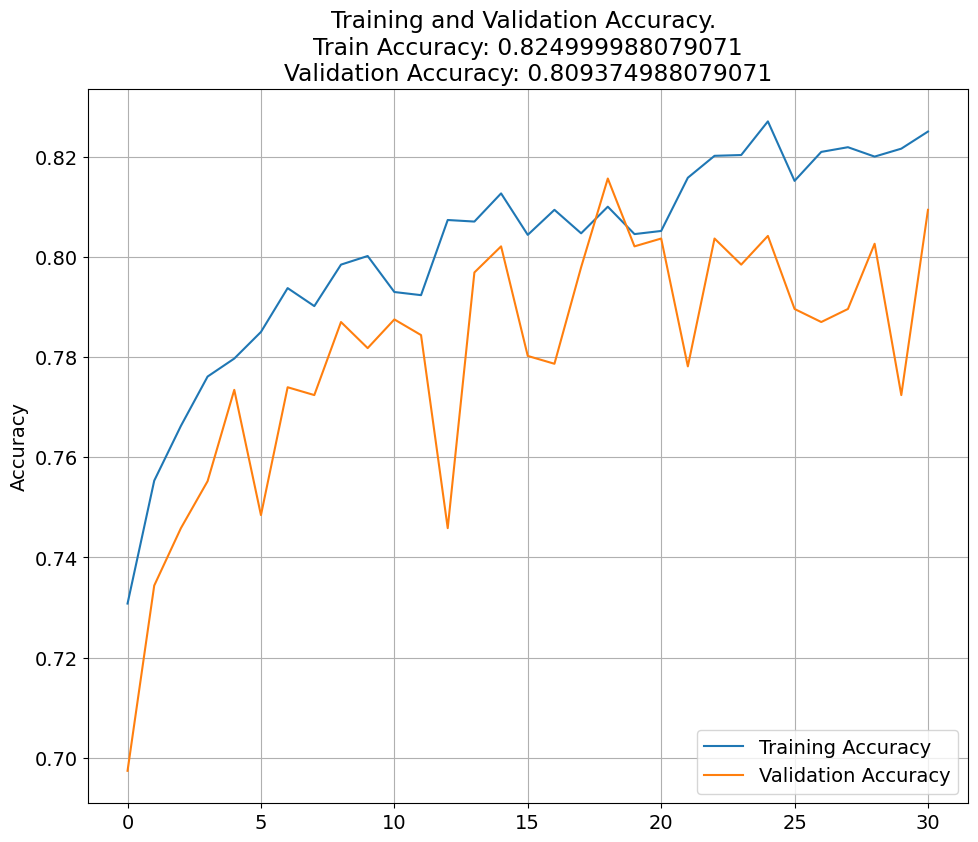

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'Training and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')
plt.tight_layout()
plt.show()

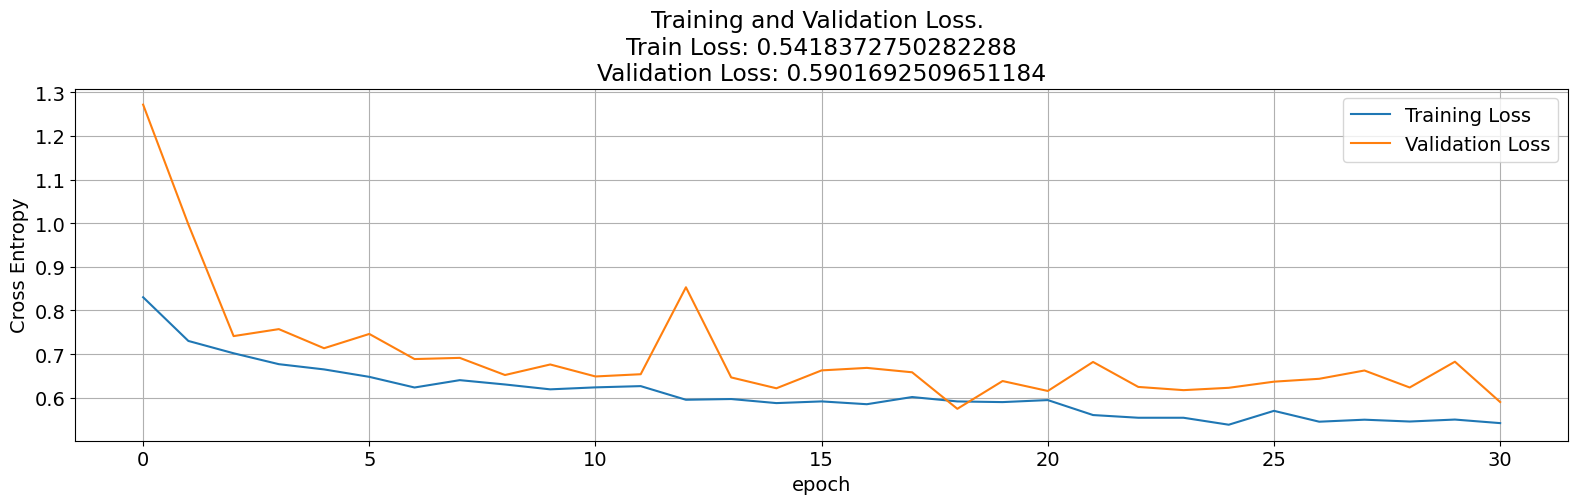

In [10]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

# ***Testing on the test data***

In [13]:
x_batch, y_batch = next(test_generator)
predictions = model.predict(x_batch)

1/1 [==============================] - 0s 53ms/step


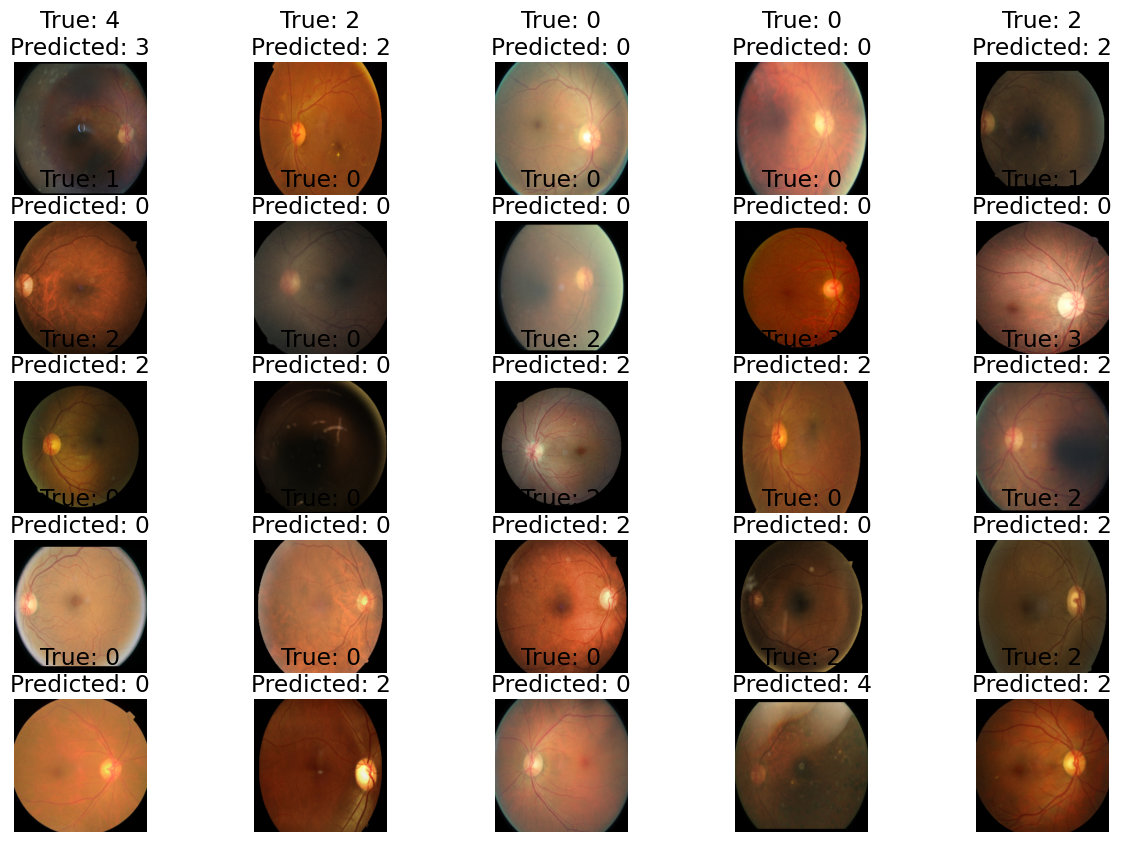

In [14]:
true_labels = np.argmax(y_batch, axis=1)

class_names = list(test_generator.class_indices.keys())

predicted_indices = np.argmax(predictions, axis=1)

plt.figure(figsize=[15, 10])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_batch[i])
    true_label = class_names[true_labels[i]]
    predicted_label = class_names[predicted_indices[i]]
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')

plt.show()

# ***Testing On an Image***

In [15]:
from tensorflow.keras.preprocessing import image

image_path = '/content/test_directory/2/0d0a21fd354f.jpg'
img = image.load_img(image_path, target_size=(img_size, img_size))
img = image.img_to_array(img)
img = img / 255.0 

img = np.expand_dims(img, axis=0)

predictions = model.predict(img)

predicted_class = np.argmax(predictions[0])

1/1 [==============================] - 3s 3s/step


In [16]:
DR = {0 : 'No DR', 1 : 'Mild DR', 2 : 'Moderate DR', 3 : 'Severe DR', 4 : 'Proliferative DR'}
DR[predicted_class]

'Moderate DR'

# ***Saving Model***

In [17]:
model.save('diabetic_eye_model.h5')